# Imports

In [1]:
import os
import csv
import json
import gzip
import pickle
import pathlib
import datetime
import operator
import itertools
import unicodedata
import collections

In [2]:
import nltk
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Constants

In [3]:
PROJECT_DIR = pathlib.Path('~/project').expanduser()
DATA_DIR = PROJECT_DIR / 'data'
CORPUS_ROOT = DATA_DIR / 'sample'

# PickledCorpusReader

In [4]:
DOC_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.json'
PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)/.*'

In [5]:
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

class PickledCorpusReader(CategorizedCorpusReader, CorpusReader):

    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        """
        Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
        the ``CategorizedCorpusReader`` constructor.  The remaining arguments
        are passed to the ``CorpusReader`` constructor.
        """
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)

    def _resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. This primarily bubbles up to
        the high level ``docs`` method, but is implemented here similar to
        the nltk ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids
    
    def feeds(self):
        data = self.open('feeds.json')
        return json.load(data)

    def docs(self, fileids=None, categories=None):
        """
        Returns the document loaded from a pickled object for every file in
        the corpus. Similar to the BaleenCorpusReader, this uses a generator
        to acheive memory safe iteration.
        """
        # Resolve the fileids and the categories
        fileids = self._resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

    def tagged_paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of (token, tag) tuples.
        """
        for doc in self.docs(fileids, categories):
            for tagged_para in doc:
                yield tagged_para
    
    def paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of tokens.
        """
        for tagged_para in self.tagged_paras(fileids, categories):
            yield [[word for word, tag in tagged_sent]
                   for tagged_sent in tagged_para]

    def tagged_sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        (token, tag) tuples.
        """
        for tagged_para in self.tagged_paras(fileids, categories):
            for tagged_sent in tagged_para:
                yield tagged_sent
                
    def sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        tokens.
        """
        for tagged_sent in self.tagged_sents(fileids, categories):
            yield [word for word, tag in tagged_sent]
    
    def tagged_words(self, fileids=None, categories=None):
        """
        Returns a generator of (token, tag) tuples.
        """
        for sent in self.tagged_sents(fileids, categories):
            for token, tag in sent:
                yield token, tag

    def words(self, fileids=None, categories=None):
        """
        Returns a generator of tokens.
        """
        for word, tag in self.tagged_words(fileids, categories):
            yield word
    
    def describe(self, fileids=None, categories=None):
        """
        Performs a single pass of the corpus and
        returns a dictionary with a variety of metrics
        concerning the state of the corpus.
        """
        started = time.time()
        
        # Structures to perform counting.
        counts  = nltk.FreqDist()
        tokens  = nltk.FreqDist()

        # Perform single pass over paragraphs, tokenize and count
        for para in self.paras(fileids, categories):
            counts['paras'] += 1
            
            for sent in para:
                counts['sents'] += 1
                
                for word, tag in sent:
                    counts['words'] += 1
                    tokens[word] += 1
        
        # Compute the number of files and categories in the corpus
        n_fileids = len(self._resolve(fileids, categories) or self.fileids())
        n_topics  = len(self.categories(self._resolve(fileids, categories)))

        # Return data structure with information
        return {
            'files':  n_fileids,
            'topics': n_topics,
            'paras':  counts['paras'],
            'sents':  counts['sents'],
            'words':  counts['words'],
            'vocab':  len(tokens),
            'lexdiv': counts['words'] / len(tokens),
            'ppdoc':  counts['paras'] / n_fileids,
            'sppar':  counts['sents'] / counts['paras'],
            'secs':   time.time() - started,
        }

In [6]:
corpus = PickledCorpusReader(root=CORPUS_ROOT.as_posix())
words = collections.Counter(corpus.words())

print(f"{len(words.keys()):,} vocabulary {sum(words.values()):,} word count")

58,748 vocabulary 1,624,862 word count


# TextNormalizer

In [7]:
from nltk.corpus import wordnet as wn

class TextNormalizer(object):

    def __init__(self, language='english'):
        self.stopwords  = frozenset(nltk.corpus.stopwords.words(language))
        self.lemmatizer = nltk.WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P')
            for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token) and not self.is_stopword(token)
        ]

# Visualizing Feature Space

## Visual Feature Analysis

### n-gram viewer

In [8]:
PUBDATES_PATH = DATA_DIR / 'pubdates.csv.gz' # mapping of docid to pubdate
WORDSERIES_PATH = pathlib.Path('wordseries.json') # word:date count
DATE_FORMAT = "%Y-%m-%d"

In [9]:
def docid(fileid):
    """
    Returns the docid parsed from the file id
    """
    fname = os.path.basename(fileid)
    return os.path.splitext(fname)[0]

In [10]:
def parse_date(ts):
    """
    Helper function to handle weird mongo datetime output.
    """
    return datetime.datetime.strptime(ts.split()[0], DATE_FORMAT)

In [11]:
def load_pubdates(fileids, path=PUBDATES_PATH):
    fileids = frozenset(map(docid, fileids))

    with gzip.open(path, 'rt') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        return {
            fileid: parse_date(raw_date)
            for fileid, raw_date in reader
            if fileid in fileids and raw_date
        }

In [12]:
class WordSeries(object):

    @classmethod
    def load(cls, path):
        """
        Load the word series from disk.
        """
        obj = cls()
        with path.open() as f:
            for line in f:
                data = json.loads(line.strip())
                word = data['word']
                for raw_date, count in data['series'].items():
                    date = datetime.datetime.strptime(raw_date, DATE_FORMAT)
                    obj.words[word][date] = count
        return obj

    def __init__(self):
        # a map of token -> date -> count
        self.words = collections.defaultdict(
            collections.Counter
        )

    def __len__(self):
        return len(self.words)

    def __getitem__(self, key):
        if key not in self.words:
            raise KeyError(f'{key!r} not in word list')
        
        dates, counts = zip(*sorted(self.words[key].items(),
                                    key=operator.itemgetter(0)))

        # Return a timeseries for the specified key
        return pd.Series(counts, index=dates, name=key)

    def read(self, corpus, pubdates_path=PUBDATES_PATH):
        """
        Creates a time series for each unique word in the corpus, normalizing
        the words and filtering out stopwords, etc.
        """
        normalize = TextNormalizer().normalize
        pubdates = load_pubdates(corpus.fileids(), pubdates_path)

        # count all tokens over time
        for fileid, doc in zip(corpus.fileids(), corpus.docs()):
            fileid = docid(fileid)
            pubdate = pubdates.get(fileid, None)
            if not pubdate:
                continue

            # self.words hold token to date to count
            for token in normalize(doc):
                self.words[token][pubdate] += 1

    def dump(self, path=WORDSERIES_PATH):
        """
        Dump the word series to disk an easily parseable manner (jsonl).
        """
        with path.open('w') as f:
            for word, counter in self.words.items():
                obj = {'word': word,
                       'series': {date.strftime(DATE_FORMAT): count
                                  for date, count in counter.items()}}
                f.write(json.dumps(obj))
                f.write('\n')

    def plot(self, terms, figsize, xlim):
        """
        Plot the word series for each term in the terms list
        """
        data = (
            pd.DataFrame({term: self[term]
                          for term in terms})
            .resample('D')
            .sum()
        )
        return data.plot(
            title='Token Frequency over Time',
            xlabel='publication date',
            ylabel='word count',
            xlim=xlim,
            figsize=figsize,
            legend=True
        )

In [13]:
corpus = PickledCorpusReader(root=CORPUS_ROOT.as_posix())

if not WORDSERIES_PATH.exists():
    # Build the word series and dump it to disk.
    series = WordSeries()
    series.read(corpus)
    series.dump()
    print(f'wrote {len(series)} word series to {WORDSERIES_PATH}')
else:
    series = WordSeries.load(WORDSERIES_PATH)

wrote 42358 word series to wordseries.json


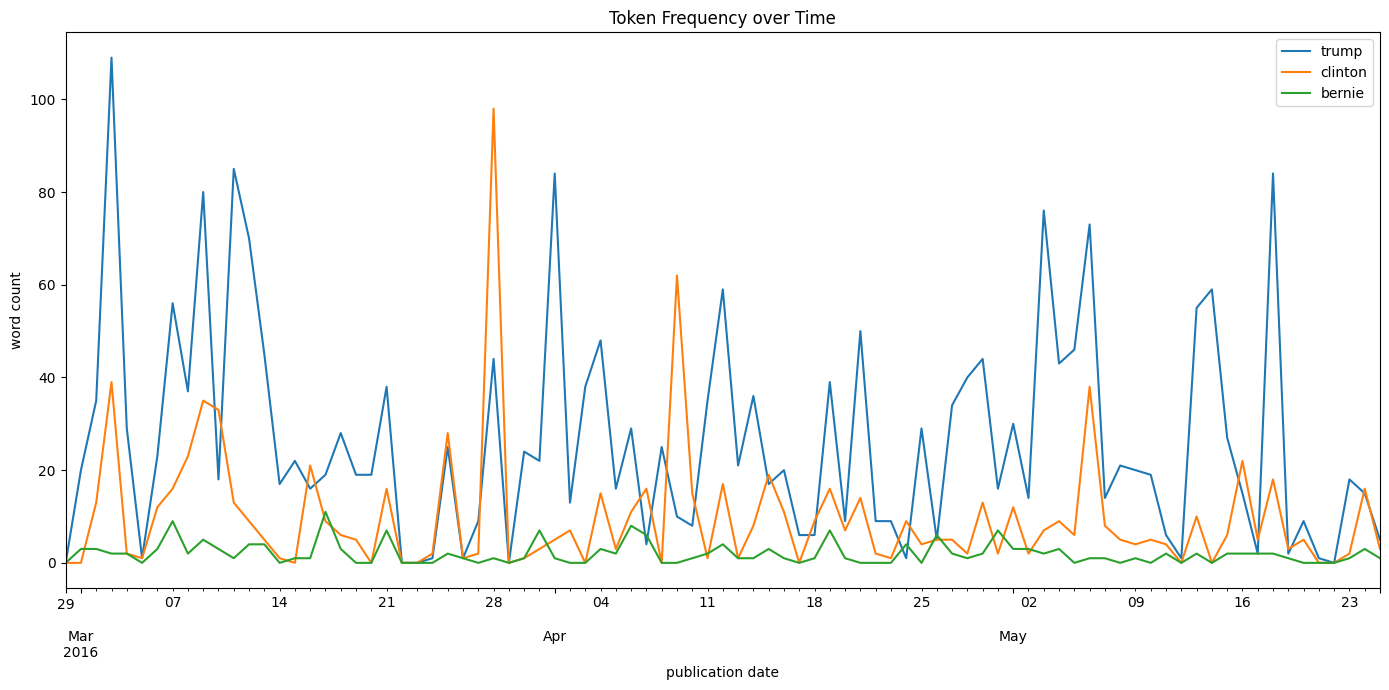

In [14]:
series.plot(
    terms=['trump', 'clinton', 'bernie'],
    figsize=(14, 7),
    xlim=('2016-02-29','2016-05-25')
)
plt.tight_layout()
plt.show()

### Network visualization

In [15]:
OZ_PATH = DATA_DIR / 'oz.json'

In [16]:
def cooccurrence(chapters, cast):
    return collections.Counter(
        (x, y)
        for title, chapter in chapters.items()
        for sent in nltk.sent_tokenize(chapter)
        for x, y in itertools.combinations(cast, 2)
        if x in sent and y in sent
    )

In [17]:
with OZ_PATH.open(encoding='utf-8-sig') as f:
    oz_data = json.load(f)

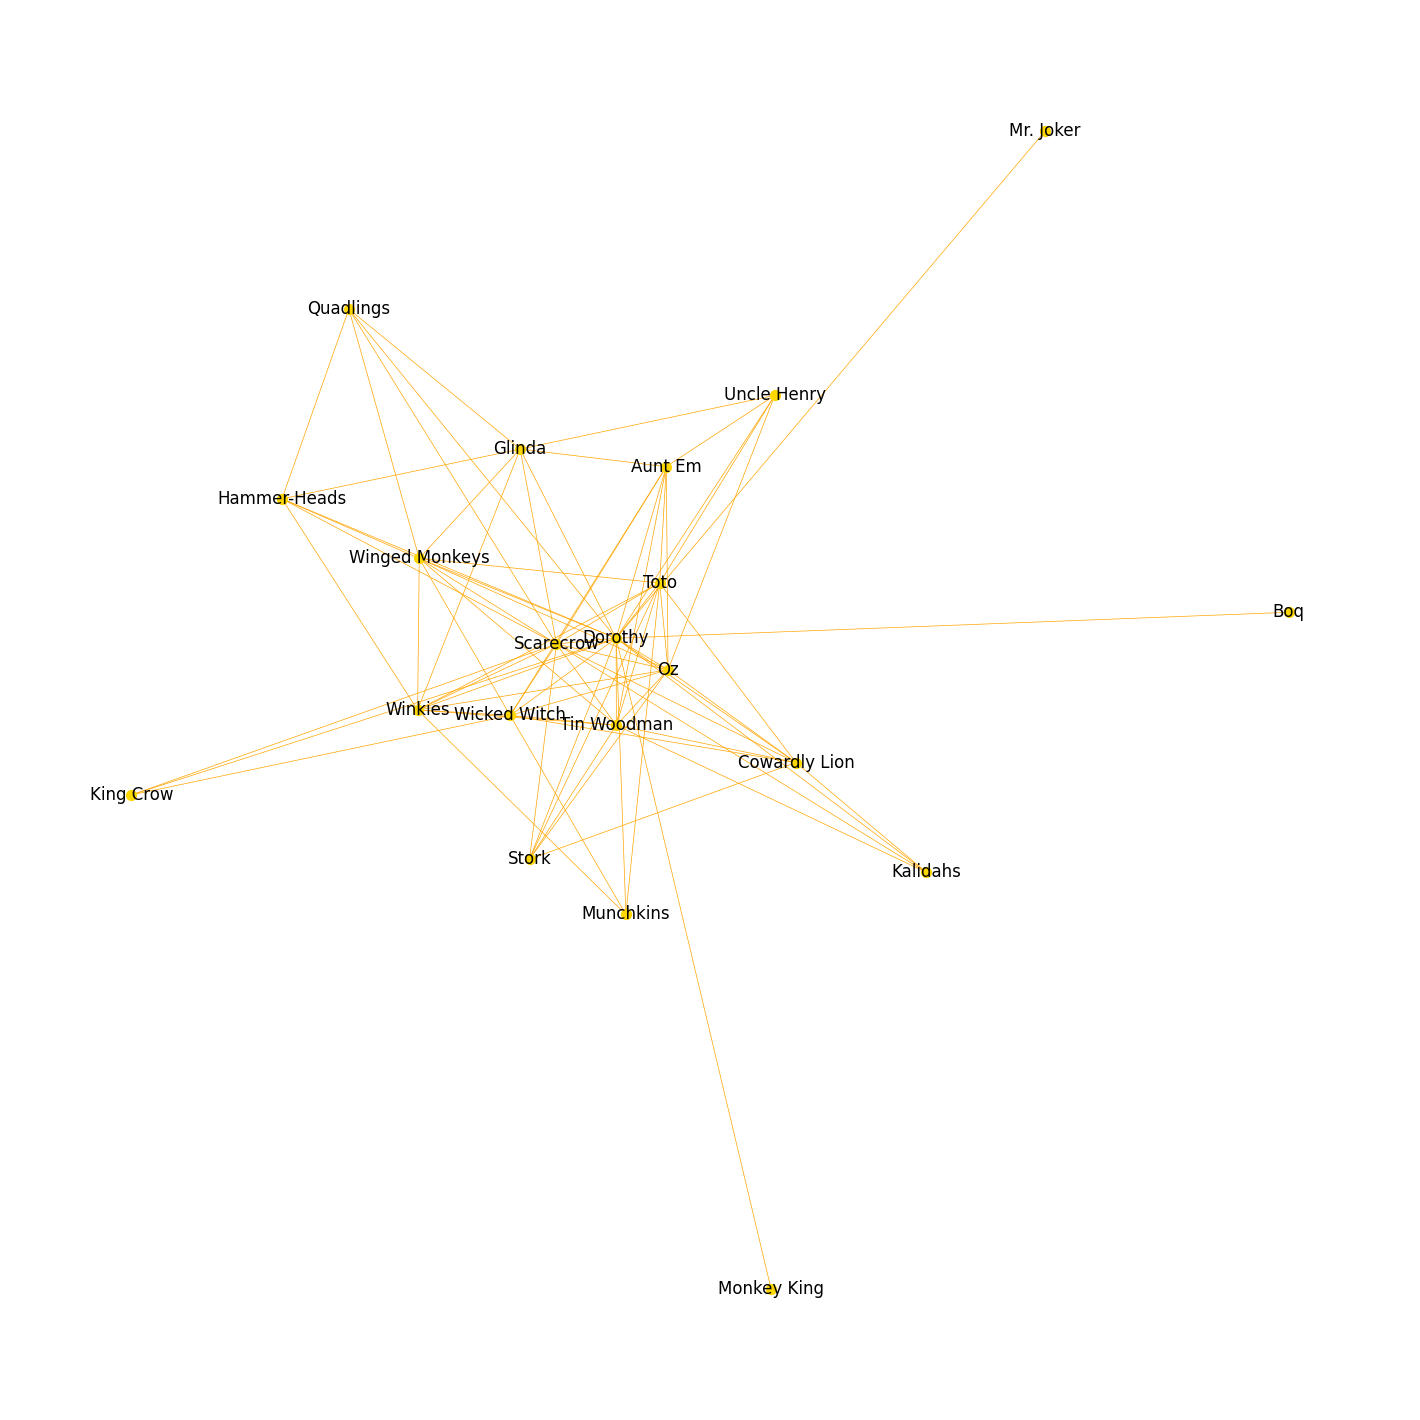

In [18]:
G = nx.Graph()
G.name = 'The Social Network of Oz'
pairs = cooccurrence(oz_data['chapters'], oz_data['cast'])
for (x, y), weight in pairs.items():
    G.add_edge(x, y, weight=weight)

# Make Dorothy the center
D = nx.ego_graph(G, 'Dorothy')
edges, weights = zip(*nx.get_edge_attributes(D, 'weight').items())

# Push nodes away that are less related to Dorothy
pos = nx.spring_layout(D, k=.5, iterations=40)

plt.figure(figsize=(14, 14))
nx.draw(D, pos, node_color='gold', node_size=50, edgelist=edges,
        width=.5, edge_color='orange', with_labels=True, font_size=12)
plt.show()

### Co-occurrence plots

In [19]:
def matrix(chapters, cast):
    combos = collections.Counter(
        (x, y)
        for title, chapter in chapters.items()
        for sent in nltk.sent_tokenize(chapter)
        for x, y in itertools.combinations_with_replacement(cast, 2)
        if x in sent and y in sent
    )
    return [[max(combos[x, y], combos[y, x]) for y in cast]
            for x in cast]

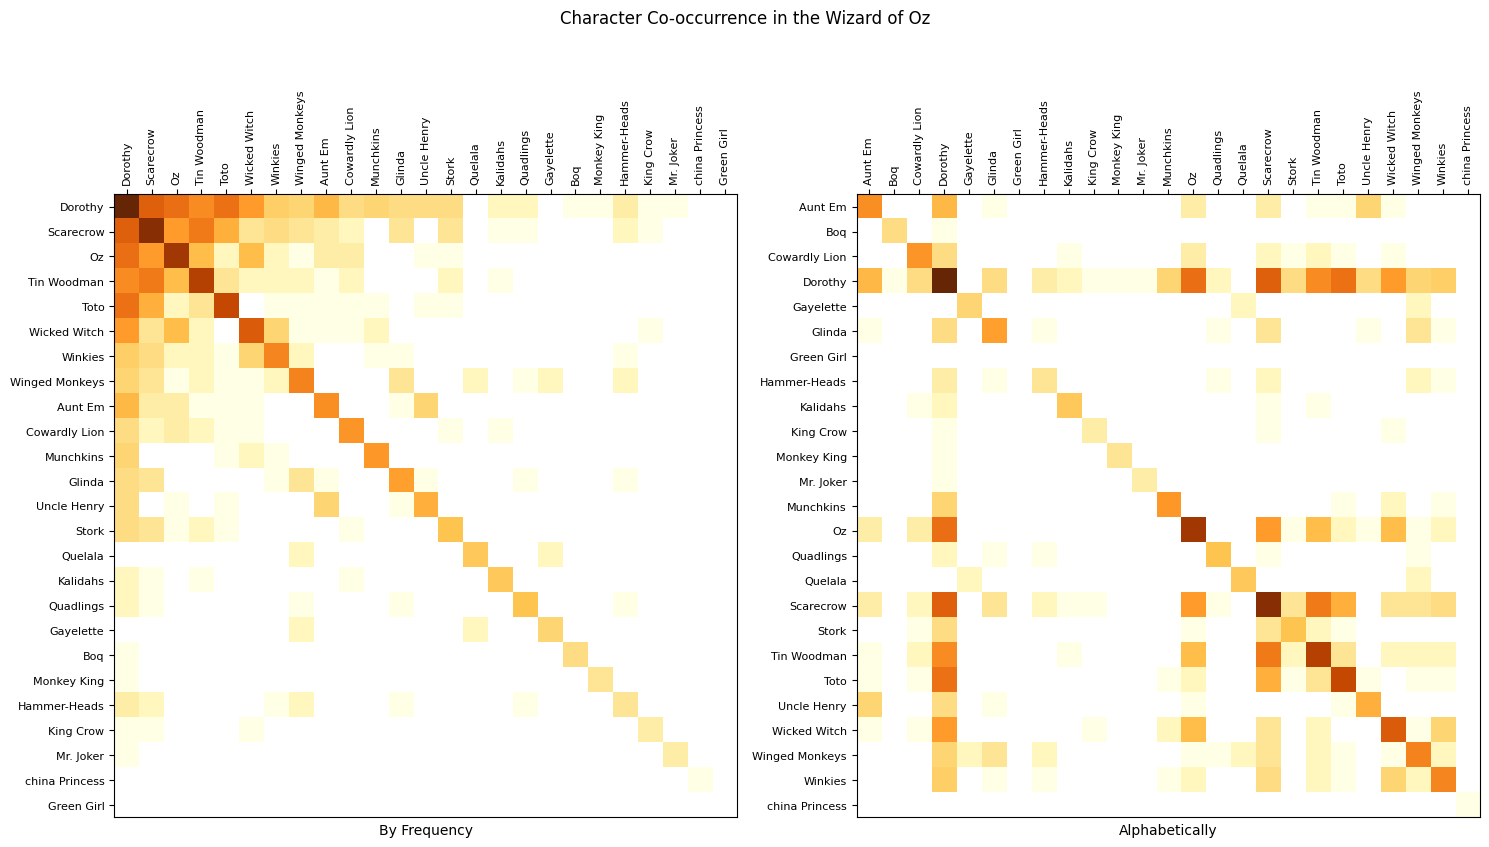

In [20]:
from matplotlib.colors import LogNorm

# First make the matrices
# By frequency
mtx = matrix(oz_data['chapters'], oz_data['cast'])
# And alphabetically
alpha_cast = sorted(oz_data['cast'])
alpha_mtx = matrix(oz_data['chapters'], alpha_cast)

# Now create the plots
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('Character Co-occurrence in the Wizard of Oz', fontsize=12)

n = len(oz_data['cast'])
x_tick_marks = np.arange(n)
y_tick_marks = np.arange(n)

ax1 = plt.subplot(121)
ax1.set_xticks(x_tick_marks)
ax1.set_yticks(y_tick_marks)
ax1.set_xticklabels(oz_data['cast'], fontsize=8, rotation=90)
ax1.set_yticklabels(oz_data['cast'], fontsize=8)
ax1.xaxis.tick_top()
ax1.set_xlabel('By Frequency')
plt.imshow(mtx, norm=LogNorm(), interpolation='nearest', cmap='YlOrBr')

ax2 = plt.subplot(122)
ax2.set_xticks(x_tick_marks)
ax2.set_yticks(y_tick_marks)
ax2.set_xticklabels(alpha_cast, fontsize=8, rotation=90)
ax2.set_yticklabels(alpha_cast, fontsize=8)
ax2.xaxis.tick_top()
ax2.set_xlabel('Alphabetically')
plt.imshow(alpha_mtx, norm=LogNorm(), interpolation='nearest', cmap='YlOrBr')

plt.tight_layout()
plt.show()

### Text x-rays and dispersion plots

## Guided Feature Engineering

### Part-of-speech tagging

### Most informative features

# Model Diagnostics

## Visualizing Clusters

## Visualizing Classes

## Diagnosing Classification Error

### Classification report heatmaps

### Confusion matrices

# Visual Steering

## Silhouette Scores and Elbow Curves

### Silhouette scores

### Elbow curves